Aside from the head, the MPII Dataset does not include bounding box coordinates (we won't be using the head bounding box anyways). Thus, I will need to write some code that can approximate the coordinates for limbs using the existing joint coordinates in the dataset.

First, get the images.

In [50]:
from google.colab import drive
import shutil
import pandas as pd, csv
from tqdm.auto import tqdm
import math

In [51]:
drive.mount('/content/drive')
with open(f'/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/sports_annotations_no_box.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/sports_annotations_no_box.csv", "sports_annotations_no_box.csv")

dataset = pd.read_csv('sports_annotations_no_box.csv')
imgs = set()
for i in dataset.index:
  imgs.add(dataset["NAME"][i])

Mounted at /content/drive


In [55]:

with open('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'images.tar.gz')

drive.flush_and_unmount()

In [56]:
!tar xvfz images.tar.gz

Streaming output truncated to the last 5000 lines.
images_data/095307277.jpg
images_data/061041120.jpg
images_data/002503634.jpg
images_data/007361826.jpg
images_data/005752678.jpg
images_data/009496528.jpg
images_data/044416878.jpg
images_data/018232876.jpg
images_data/057195110.jpg
images_data/056265542.jpg
images_data/052762446.jpg
images_data/070177577.jpg
images_data/019333923.jpg
images_data/022531693.jpg
images_data/034901871.jpg
images_data/079744892.jpg
images_data/014814122.jpg
images_data/085918189.jpg
images_data/081055333.jpg
images_data/052437549.jpg
images_data/004916083.jpg
images_data/049262510.jpg
images_data/085426769.jpg
images_data/012331849.jpg
images_data/024183499.jpg
images_data/073941146.jpg
images_data/079870457.jpg
images_data/060350550.jpg
images_data/046656171.jpg
images_data/038110051.jpg
images_data/049451546.jpg
images_data/078396079.jpg
images_data/068915723.jpg
images_data/080611182.jpg
images_data/089352075.jpg
images_data/004836271.jpg
images_data/0

In [57]:
import os
print(len(os.listdir('images_data')))

9002


In [58]:
dataset

,Unnamed: 0,Unnamed: 0.1,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,pelvis_X,pelvis_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,r wrist_X,r wrist_Y,r elbow_X,r elbow_Y,r shoulder_X,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,0,015601864.jpg,620,394,616,269,573,185,647,188,661,221,656,231,610,187,647,176,637.0201,189.8183,695.9799,108.1817,606,217,553,161,601,167,692,185,693,240,688,313,3.021046,curling,sports
1,1,0,015599452.jpg,-1,-1,-1,-1,806,543,720,593,-1,-1,-1,-1,763,568,683,290,682.0000,256.0000,676.0000,68.0000,563,296,555,410,647,281,719,299,711,516,545,466,5.641276,curling,sports
2,2,0,005808361.jpg,804,711,816,510,908,438,1040,454,906,528,883,707,974,446,985,253,982.7591,235.9694,962.2409,80.0306,869,214,798,340,902,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,3,0,086617615.jpg,301,461,305,375,201,340,294,342,335,370,331,455,248,341,279,263,277.0210,268.7786,305.9790,184.2214,328,354,260,335,244,261,314,264,327,320,362,346,2.681349,curling,sports
4,4,0,060111501.jpg,980,322,896,318,865,248,943,226,948,290,881,349,904,237,858,135,871.1877,180.4244,835.8123,58.5756,772,294,754,247,792,147,923,123,995,163,961,223,3.806403,curling,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8997,17311,0,012741552.jpg,855,305,860,233,850,167,871,173,878,245,853,299,861,170,879,115,883.5063,107.4895,904.4937,72.5105,870,170,837,146,860,105,898,125,894,166,900,195,1.223765,"moto-cross, off-road motor sports, all-terrain...",sports
8998,17312,0,089258378.jpg,542,298,623,214,608,132,650,165,664,256,588,359,629,149,741,92,740.1674,92.2345,812.8326,71.7655,674,175,640,121,715,87,766,96,736,154,755,220,2.264791,"moto-cross, off-road motor sports, all-terrain...",sports
8999,17313,0,076912890.jpg,761,679,756,618,756,551,807,561,801,634,796,711,782,556,767,406,765.6631,390.9975,759.3369,320.0025,610,323,645,368,711,391,822,420,855,501,860,567,2.138291,"moto-cross, off-road motor sports, all-terrain...",sports
9000,17314,0,099616030.jpg,704,336,693,284,744,281,742,301,685,323,696,363,743,291,775,250,775.1853,238.3288,775.8147,198.6712,716,238,759,252,776,240,773,259,766,292,739,281,1.189877,"moto-cross, off-road motor sports, all-terrain...",sports


Next, view the existing coordinates.

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

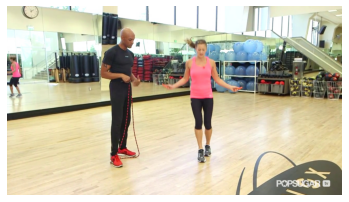

In [60]:
im = plt.imread("images_data/000003072.jpg")
plt.axis('off')
plt.imshow(im)

In [61]:
# Will edit to be more efficient when saving a csv with bounding boxes later
index = -1
for i in dataset.index:
  if dataset["NAME"][i] == "000003072.jpg":
    print(i)
    index = i
    break

1600


In [62]:
# Note, does not take into account when the joints aren't in view (those are stored as -1). This is just a testing function
def show_points(index, table):
  im = table["NAME"][index]
  im = plt.imread(f"images_data/{im}")
  plt.axis('off')
 
  plt.scatter([dataset["r ankle_X"][i]], [dataset["r ankle_Y"][i]], s=5)
  plt.scatter([dataset["r knee_X"][i]], [dataset["r knee_Y"][i]], s=5)
  plt.scatter([dataset["r hip_X"][i]], [dataset["r hip_Y"][i]], s=5)
  plt.scatter([dataset["l hip_X"][i]], [dataset["l hip_Y"][i]], s=5)
  plt.scatter([dataset["l knee_X"][i]], [dataset["l knee_Y"][i]], s=5)
  plt.scatter([dataset["l ankle_X"][i]], [dataset["l ankle_Y"][i]], s=5)
  plt.scatter([dataset["pelvis_X"][i]], [dataset["pelvis_Y"][i]], s=5)
  plt.scatter([dataset["thorax_X"][i]], [dataset["thorax_Y"][i]], s=5)
  plt.scatter([dataset["upper neck_X"][i]], [dataset["upper neck_Y"][i]], s=5)
  plt.scatter([dataset["head top_X"][i]], [dataset["head top_Y"][i]], s=5)
  plt.scatter([dataset["r wrist_X"][i]], [dataset["r wrist_Y"][i]], s=5)
  plt.scatter([dataset["r elbow_X"][i]], [dataset["r elbow_Y"][i]], s=5)
  plt.scatter([dataset["r shoulder_X"][i]], [dataset["r shoulder_Y"][i]], s=5)
  plt.scatter([dataset["l shoulder_X"][i]], [dataset["l shoulder_Y"][i]], s=5)
  plt.scatter([dataset["l elbow_X"][i]], [dataset["l elbow_Y"][i]], s=5)
  plt.scatter([dataset["l wrist_X"][i]], [dataset["l wrist_Y"][i]], s=5)
  plt.imshow(im)

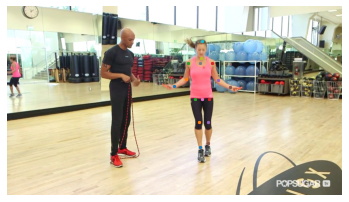

In [63]:
show_points(index, dataset)

Based on some preliminary observations, a rough approximation for the width of, for example, an upper arm is about half its length. I must also take the angle from one point to the other into account.

In [119]:
math.sqrt((2*2) / 3)

1.1547005383792515

In [128]:

def box_from_coords(a, b): #a and b are coordinate tuples
  if a[0] == -1 or a[1] == -1 or b[0] == -1 or b[1] == -1:
    return -1, -1, -1, -1
  xl = min(a[0], b[0])
  yd = min(a[1], b[1])
  xs = abs(a[0] - b[0])
  ys = abs(a[1] - b[1])
  if xs == 0:
    length = ys
  else:
    length = math.sqrt((ys*ys) / (xs*xs))
  # Want a minimum width in respect to length
  minW = minH = length / 2
  if minW > xs:
    xs = minW
  if minH > ys:
    ys = minH
  return xl, yd, xs, ys

  


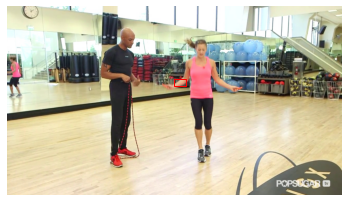

In [129]:
im = plt.imread("images_data/000003072.jpg")
xl, yd, xs, ys = box_from_coords((dataset["r elbow_X"][index], dataset["r elbow_Y"][index]), (dataset["r wrist_X"][index], dataset["r wrist_Y"][index]))
plt.imshow(im)
plt.axis('off')
ax = plt.gca()
box = patches.Rectangle((xl, yd), xs, ys, ec='r', fc='none')
ax.add_patch(box)

Now to reformat the dataset.

In [130]:
box_from_coords((dataset["l ankle_X"][0], dataset["l ankle_Y"][0]), (dataset["l knee_X"][0], dataset["l knee_Y"][0]))

(656, 221, 5, 10)

In [131]:
l_shin = []
r_shin = []
l_thigh = []
r_thigh = []
torso = []
l_forearm = []
r_forearm = []
l_uparm = []
r_uparm = []
ims = []

for i in dataset.index:
  l_shin.append(box_from_coords((dataset["l ankle_X"][i], dataset["l ankle_Y"][i]), (dataset["l knee_X"][i], dataset["l knee_Y"][i])))
  r_shin.append(box_from_coords((dataset["r ankle_X"][i], dataset["r ankle_Y"][i]), (dataset["r knee_X"][i], dataset["r knee_Y"][i])))
  l_thigh.append(box_from_coords((dataset["l hip_X"][i], dataset["l hip_Y"][i]), (dataset["l knee_X"][i], dataset["l knee_Y"][i])))
  r_thigh.append(box_from_coords((dataset["r hip_X"][i], dataset["r hip_Y"][i]), (dataset["r knee_X"][i], dataset["r knee_Y"][i])))
  tors = box_from_coords((dataset["l shoulder_X"][i], dataset["l shoulder_Y"][i]), (dataset["r hip_X"][i], dataset["r hip_Y"][i]))
  if tors == (-1, -1, -1, -1):
    tors = box_from_coords((dataset["r shoulder_X"][i], dataset["r shoulder_Y"][i]), (dataset["l hip_X"][i], dataset["l hip_Y"][i]))
  torso.append(tors)
  l_forearm.append(box_from_coords((dataset["l elbow_X"][i], dataset["l elbow_Y"][i]), (dataset["l wrist_X"][i], dataset["l wrist_Y"][i])))
  r_forearm.append(box_from_coords((dataset["r elbow_X"][i], dataset["r elbow_Y"][i]), (dataset["r wrist_X"][i], dataset["r wrist_Y"][i])))
  l_uparm.append(box_from_coords((dataset["l shoulder_X"][i], dataset["l shoulder_Y"][i]), (dataset["l elbow_X"][i], dataset["l elbow_Y"][i])))
  r_uparm.append(box_from_coords((dataset["r shoulder_X"][i], dataset["r shoulder_Y"][i]), (dataset["r elbow_X"][i], dataset["r elbow_Y"][i])))
  ims.append(dataset["NAME"][i])


In [132]:
data = {
    "l_shin": l_shin,
    "r_shin": r_shin,
    "l_thigh": l_thigh,
    "r_thigh": r_thigh,
    "torso": torso,
    "l_forearm": l_forearm,
    "r_forearm": r_forearm,
    "l_uparm": l_uparm,
    "r_uparm": r_uparm,
}
df = pd.DataFrame(data, index=ims)

In [133]:
df

,l_shin,r_shin,l_thigh,r_thigh,torso,l_forearm,r_forearm,l_uparm,r_uparm
015601864.jpg,"(656, 221, 5, 10)","(616, 269, 15.625, 125)","(647, 188, 14, 33)","(573, 185, 43, 84)","(573, 185, 119, 0)","(688, 240, 7.3, 73)","(553, 161, 53, 56)","(692, 185, 27.5, 55)","(553, 161, 48, 6)"
015599452.jpg,"(-1, -1, -1, -1)","(-1, -1, -1, -1)","(-1, -1, -1, -1)","(-1, -1, -1, -1)","(719, 299, 87, 244)","(545, 466, 166, 50)","(555, 296, 8, 114)","(711, 299, 13.5625, 217)","(555, 281, 92, 129)"
005808361.jpg,"(883, 528, 23, 179)","(804, 510, 12, 201)","(906, 454, 134, 74)","(816, 438, 92, 72)","(908, 253, 159, 185)","(1142, 353, 25, 125)","(798, 214, 71, 126)","(1067, 253, 100, 100)","(798, 253, 104, 87)"
086617615.jpg,"(331, 370, 10.625, 85)","(301, 375, 10.75, 86)","(294, 342, 41, 28)","(201, 340, 104, 35)","(201, 264, 113, 76)","(327, 320, 35, 26)","(260, 335, 68, 19)","(314, 264, 13, 56)","(244, 261, 16, 74)"
060111501.jpg,"(881, 290, 67, 59)","(896, 318, 84, 4)","(943, 226, 6.4, 64)","(865, 248, 31, 70)","(865, 123, 58, 125)","(961, 163, 34, 60)","(754, 247, 18, 47)","(923, 123, 72, 40)","(754, 147, 38, 100)"
...,...,...,...,...,...,...,...,...,...
012741552.jpg,"(853, 245, 25, 54)","(855, 233, 7.2, 72)","(871, 173, 7, 72)","(850, 167, 10, 66)","(850, 125, 48, 42)","(894, 166, 6, 29)","(837, 146, 33, 24)","(894, 125, 5.125, 41)","(837, 105, 23, 41)"
089258378.jpg,"(588, 256, 76, 103)","(542, 214, 81, 84)","(650, 165, 14, 91)","(608, 132, 15, 82)","(608, 96, 158, 36)","(736, 154, 19, 66)","(640, 121, 34, 54)","(736, 96, 30, 58)","(640, 87, 75, 34)"
076912890.jpg,"(796, 634, 7.7, 77)","(756, 618, 6.1, 61)","(801, 561, 6.083333333333333, 73)","(756, 551, 33.5, 67)","(756, 420, 66, 131)","(855, 501, 6.6000000000000005, 66)","(610, 323, 35, 45)","(822, 420, 33, 81)","(645, 368, 66, 23)"
099616030.jpg,"(685, 323, 11, 40)","(693, 284, 11, 52)","(685, 301, 57, 22)","(693, 281, 51, 3)","(744, 259, 29, 22)","(739, 281, 27, 11)","(716, 238, 43, 14)","(766, 259, 7, 33)","(759, 240, 17, 12)"


(-0.5, 1279.5, 719.5, -0.5)

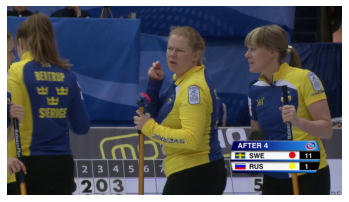

In [137]:
im = plt.imread("images_data/015599452.jpg")
plt.imshow(im)
plt.axis('off')
# r_forearm broken

Now to test how the bounding boxes look.

In [134]:
df.loc["015601864.jpg", "l_shin"]

(656, 221, 5, 10)

In [135]:
df.loc["015601864.jpg", "l_shin"][0]

656

In [136]:
cols = ["l_shin", "r_shin", "l_thigh", "r_thigh", "torso", "l_forearm", "r_forearm", "l_uparm", "r_uparm"]
count = 0
for i in df.index:
  fig = plt.figure()
  im = plt.imread(f"images_data/{i}")
  plt.axis('off')
  plt.imshow(im)
  ax = plt.gca()
  for c in cols:
    s = df.loc[i, c]   
    box = patches.Rectangle((s[0], s[1]), s[2], s[3], ec='r', fc='none')
    ax.add_patch(box)
  fig.show()
  count+=1
  if count == 20: break

Output hidden; open in https://colab.research.google.com to view.